## usage data

In [16]:
from sqlalchemy import create_engine, types
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import mysql.connector
import pandas as pd
import numpy as np
import pprint
import boto3
import boto
import json
import sys
import os

base = os.path.join('C:\\', 'Users', 'steve', 'Documents', 'reliant-scrape')
data = os.path.join(base, 'data')
pp = pprint.PrettyPrinter(indent = 1)
print('imported modules')

imported modules


## read data

In [2]:
print(os.listdir(data))

['daily_usage_08312020.csv', 'daily_usage_09052020.csv', 'daily_usage_09132020.csv', 'daily_usage_09162020.csv', 'master_energy_usage_091520.csv']


In [3]:
os.chdir(data)
use1 = pd.read_csv('daily_usage_08312020.csv', index_col = 0)
use1.head()

,Usage (kWh),Cost ($),Hi,Low
Date,,,,
2020-08-25 00:00:00,1.1,0.13,94,79
2020-08-25 01:00:00,1.2,0.14,94,79
2020-08-25 02:00:00,1.0,0.12,94,79
2020-08-25 03:00:00,1.0,0.12,94,79
2020-08-25 04:00:00,1.5,0.18,94,79


In [4]:
use2 = pd.read_csv('daily_usage_09052020.csv', index_col = 0)
use2.head()

,Usage (kWh),Cost ($),Hi,Low
Date,,,,
2020-08-31 00:00:00,1.0,0.12,96,83
2020-08-31 01:00:00,0.9,0.11,96,83
2020-08-31 02:00:00,0.9,0.11,96,83
2020-08-31 03:00:00,0.9,0.10,96,83
2020-08-31 04:00:00,0.9,0.10,96,83


In [5]:
use3 = pd.read_csv('daily_usage_09132020.csv', index_col = 0)
use3.head()

,Usage (kWh),Cost ($),Hi,Low
Date,,,,
2020-09-07 00:00:00,3.9,0.46,93,78
2020-09-07 01:00:00,3.5,0.41,93,78
2020-09-07 02:00:00,3.1,0.37,93,78
2020-09-07 03:00:00,1.7,0.20,93,78
2020-09-07 04:00:00,2.0,0.24,93,78


## create master df

In [6]:
master = pd.concat([use1, use2, use3], axis = 0)
master.head()

,Usage (kWh),Cost ($),Hi,Low
Date,,,,
2020-08-25 00:00:00,1.1,0.13,94,79
2020-08-25 01:00:00,1.2,0.14,94,79
2020-08-25 02:00:00,1.0,0.12,94,79
2020-08-25 03:00:00,1.0,0.12,94,79
2020-08-25 04:00:00,1.5,0.18,94,79


In [7]:
master.tail()

,Usage (kWh),Cost ($),Hi,Low
Date,,,,
2020-09-13 19:00:00,2.2,0.26,92,78
2020-09-13 20:00:00,2.0,0.24,92,78
2020-09-13 21:00:00,1.8,0.22,92,78
2020-09-13 22:00:00,2.4,0.29,92,78
2020-09-13 23:00:00,1.9,0.22,92,78


In [15]:
#master.to_csv('master_energy_usage_091520.csv')

## plots

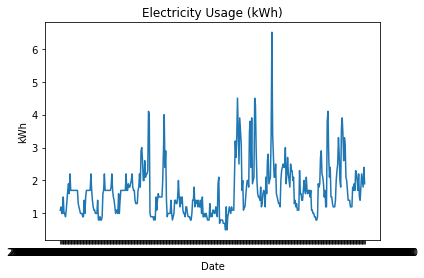

In [8]:
plt.title('Electricity Usage (kWh)')
plt.xlabel('Date')
plt.ylabel('kWh')
plt.plot(master['Usage (kWh)'])
plt.show()

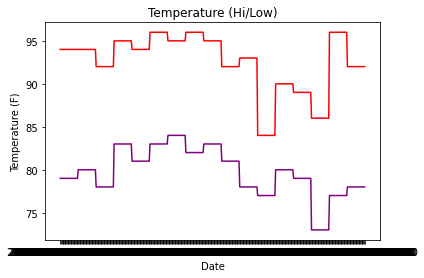

In [9]:
plt.title('Temperature (Hi/Low)')
plt.xlabel('Date')
plt.ylabel('Temperature (F)')
plt.plot(master['Hi'], color = 'red')
plt.plot(master['Low'], color = 'purple')
plt.show()

In [10]:
round(np.sum(master['Cost ($)']), 2)

81.65

## database authentication
From AWS docs: https://docs.aws.amazon.com/AmazonRDS/latest/UserGuide/UsingWithRDS.IAMDBAuth.Connecting.Python.html

In [8]:
os.chdir(base)

with open('db_creds.json', 'r') as f:
    db_creds = json.load(f)

In [9]:
os.environ['LIBMYSQL_ENABLE_CLEARTEXT_PLUGIN'] = '1'

#gets the credentials from .aws/credentials
session = boto3.Session(region_name = 'us-east-2')
client = boto3.client('rds', region_name = 'us-east-2')

In [10]:
client.list_tags_for_resource(ResourceName = db_creds['DBInstanceArn'])['TagList'][0]

{'Key': 'service', 'Value': 'reliant-energy'}

## database connection

In [52]:
def mysql_query(query, creds):
    try:
        conn =  mysql.connector.connect(host = creds['Endpoint'], 
                                        user = creds['User'], 
                                        passwd=creds['Password'], 
                                        port = creds['Port'], 
                                        database = creds['Type'])
        cur = conn.cursor()
        cur.execute(query)
        query_results = cur.fetchall()
        results_df = pd.DataFrame(query_results, columns = cur.column_names)
        return(results_df)

    except Exception as e:
        print("Database connection failed due to {}".format(e)) 

In [53]:
mysql_query('SELECT * FROM reliant_energy_db.daily_use', db_creds)

,Date,Usage (kWh),Cost ($),Hi,Low
0,2020-08-25 00:00:00,1.1,0.13,94,79
1,2020-08-25 01:00:00,1.2,0.14,94,79
2,2020-08-25 02:00:00,1.0,0.12,94,79
3,2020-08-25 03:00:00,1.0,0.12,94,79
4,2020-08-25 04:00:00,1.5,0.18,94,79
...,...,...,...,...,...
403,2020-09-13 19:00:00,2.2,0.26,92,78
404,2020-09-13 20:00:00,2.0,0.24,92,78
405,2020-09-13 21:00:00,1.8,0.22,92,78
406,2020-09-13 22:00:00,2.4,0.29,92,78


In [59]:
result = mysql_query('SELECT MIN(Date) as min_date, MAX(Date) as max_date, COUNT(*) as count FROM reliant_energy_db.daily_use', db_creds)

In [61]:
result

,min_date,max_date,count
0,2020-08-25 00:00:00,2020-09-13 23:00:00,816


In [62]:
print('found data range of {} to {} with {} records.'.format(result.min_date[0], result.max_date[0], result['count'][0]))

found data range of 2020-08-25 00:00:00 to 2020-09-13 23:00:00 with 816 records.


## upload data
https://stackoverflow.com/questions/10154633/load-csv-data-into-mysql-in-python

In [31]:
os.chdir(data)
master = pd.read_csv('master_energy_usage_091520.csv')
#master = master['Date', 'Usage (kWh)', 'Cost ($)', 'Hi', 'Low']
master.head()

,Date,Usage (kWh),Cost ($),Hi,Low
0,2020-08-25 00:00:00,1.1,0.13,94,79
1,2020-08-25 01:00:00,1.2,0.14,94,79
2,2020-08-25 02:00:00,1.0,0.12,94,79
3,2020-08-25 03:00:00,1.0,0.12,94,79
4,2020-08-25 04:00:00,1.5,0.18,94,79


In [57]:
def table_upload(df, db, table, creds):
    connect_str = 'mysql://{}:{}@{}/{}'.format(creds['User'], creds['Password'], creds['Endpoint'], db)
    engine = create_engine(connect_str)
    df.to_sql(table, con = engine, index = False, if_exists = 'append')
    print('wrote df to sql table.')

In [58]:
table_upload(master, 'reliant_energy_db', 'daily_use', db_creds)

wrote df to sql table.
